#%% [markdown]

 ## Visualize EM Clusters

In [ ]:
#%% [code]

# Includes

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from scipy.special import logsumexp
import os

np.set_printoptions(suppress=True, precision=3)
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 150

In [ ]:
#%% [code]

# Load data and run EM

from load_data import load_data_for_experiment, UNIQUE_CHOICE_COLUMNS_NO_UNCUED

# Use same experiment version as em_clusters.py
experiment_version = "V0.3_pilot"
data = load_data_for_experiment(experiment_version)

df_counts = data['df_counts']
counts = df_counts.to_numpy()
choice_columns = data['choice_columns']

In [ ]:
#%% [code]

# Multinomial mixture EM algorithm (copied from em_clusters.py)

def compute_cluster_loglikelihood(pi_j, theta_j, counts):
    """Compute log-likelihood for a single cluster."""
    return np.log(pi_j) + (counts * np.log(theta_j + 1e-12)).sum(axis=1)

def multinomial_mixture_EM(counts, n_clusters=2, max_iter=200, tol=1e-6, seed=0):
    rng = np.random.default_rng(seed)
    S, K = counts.shape
    N = counts.sum(axis=1, keepdims=True)
    # initialize cluster probabilities randomly
    theta = rng.dirichlet(np.ones(K), size=n_clusters)
    pi = np.ones(n_clusters) / n_clusters

    for it in range(max_iter):
        # --- E-step ---
        loglik = np.zeros((S, n_clusters))
        for j in range(n_clusters):
            loglik[:, j] = compute_cluster_loglikelihood(pi[j], theta[j], counts)
        r = np.exp(loglik - logsumexp(loglik, axis=1, keepdims=True))

        # --- M-step ---
        pi_new = r.mean(axis=0)
        theta_new = np.zeros_like(theta)
        for j in range(n_clusters):
            w = r[:, j:j+1]
            theta_new[j] = (w.T @ counts).ravel()
        theta_new /= theta_new.sum(axis=1, keepdims=True)

        # convergence check
        diff = np.abs(theta_new - theta).max()
        theta, pi = theta_new, pi_new
        if diff < tol:
            break

    # compute total log-likelihood
    loglik_final = np.zeros((S, n_clusters))
    for j in range(n_clusters):
        loglik_final[:, j] = compute_cluster_loglikelihood(pi[j], theta[j], counts)
    ll = logsumexp(loglik_final, axis=1).sum()

    return pi, theta, r, ll

In [ ]:
#%% [code]

# Run EM with 3 clusters (as shown in the example)

n_clusters = 3
pi, theta, r, ll = multinomial_mixture_EM(counts, n_clusters=n_clusters, seed=0)

print('Choice categories:', choice_columns)
print("Cluster probabilities:", pi)
print("Cluster means:", theta)

# Get hard cluster assignments (most likely cluster for each subject)
cluster_assignments = np.argmax(r, axis=1)

Choice categories: ['gpi zero', 'policy reuse max rew. test', 'policy reuse min rew. test', 'policy reuse uncued', 'mb/gpi', 'null trajectories']
Cluster probabilities: [0.548 0.245 0.207]
Cluster means: [[0.411 0.164 0.095 0.051 0.03  0.25 ]
 [0.088 0.363 0.309 0.037 0.017 0.186]
 [0.16  0.099 0.031 0.006 0.475 0.229]]


In [ ]:
#%% [code]

# Convert counts to proportions for visualization
# (PCA/MDS work better with normalized data)

counts_prop = counts / counts.sum(axis=1, keepdims=True)

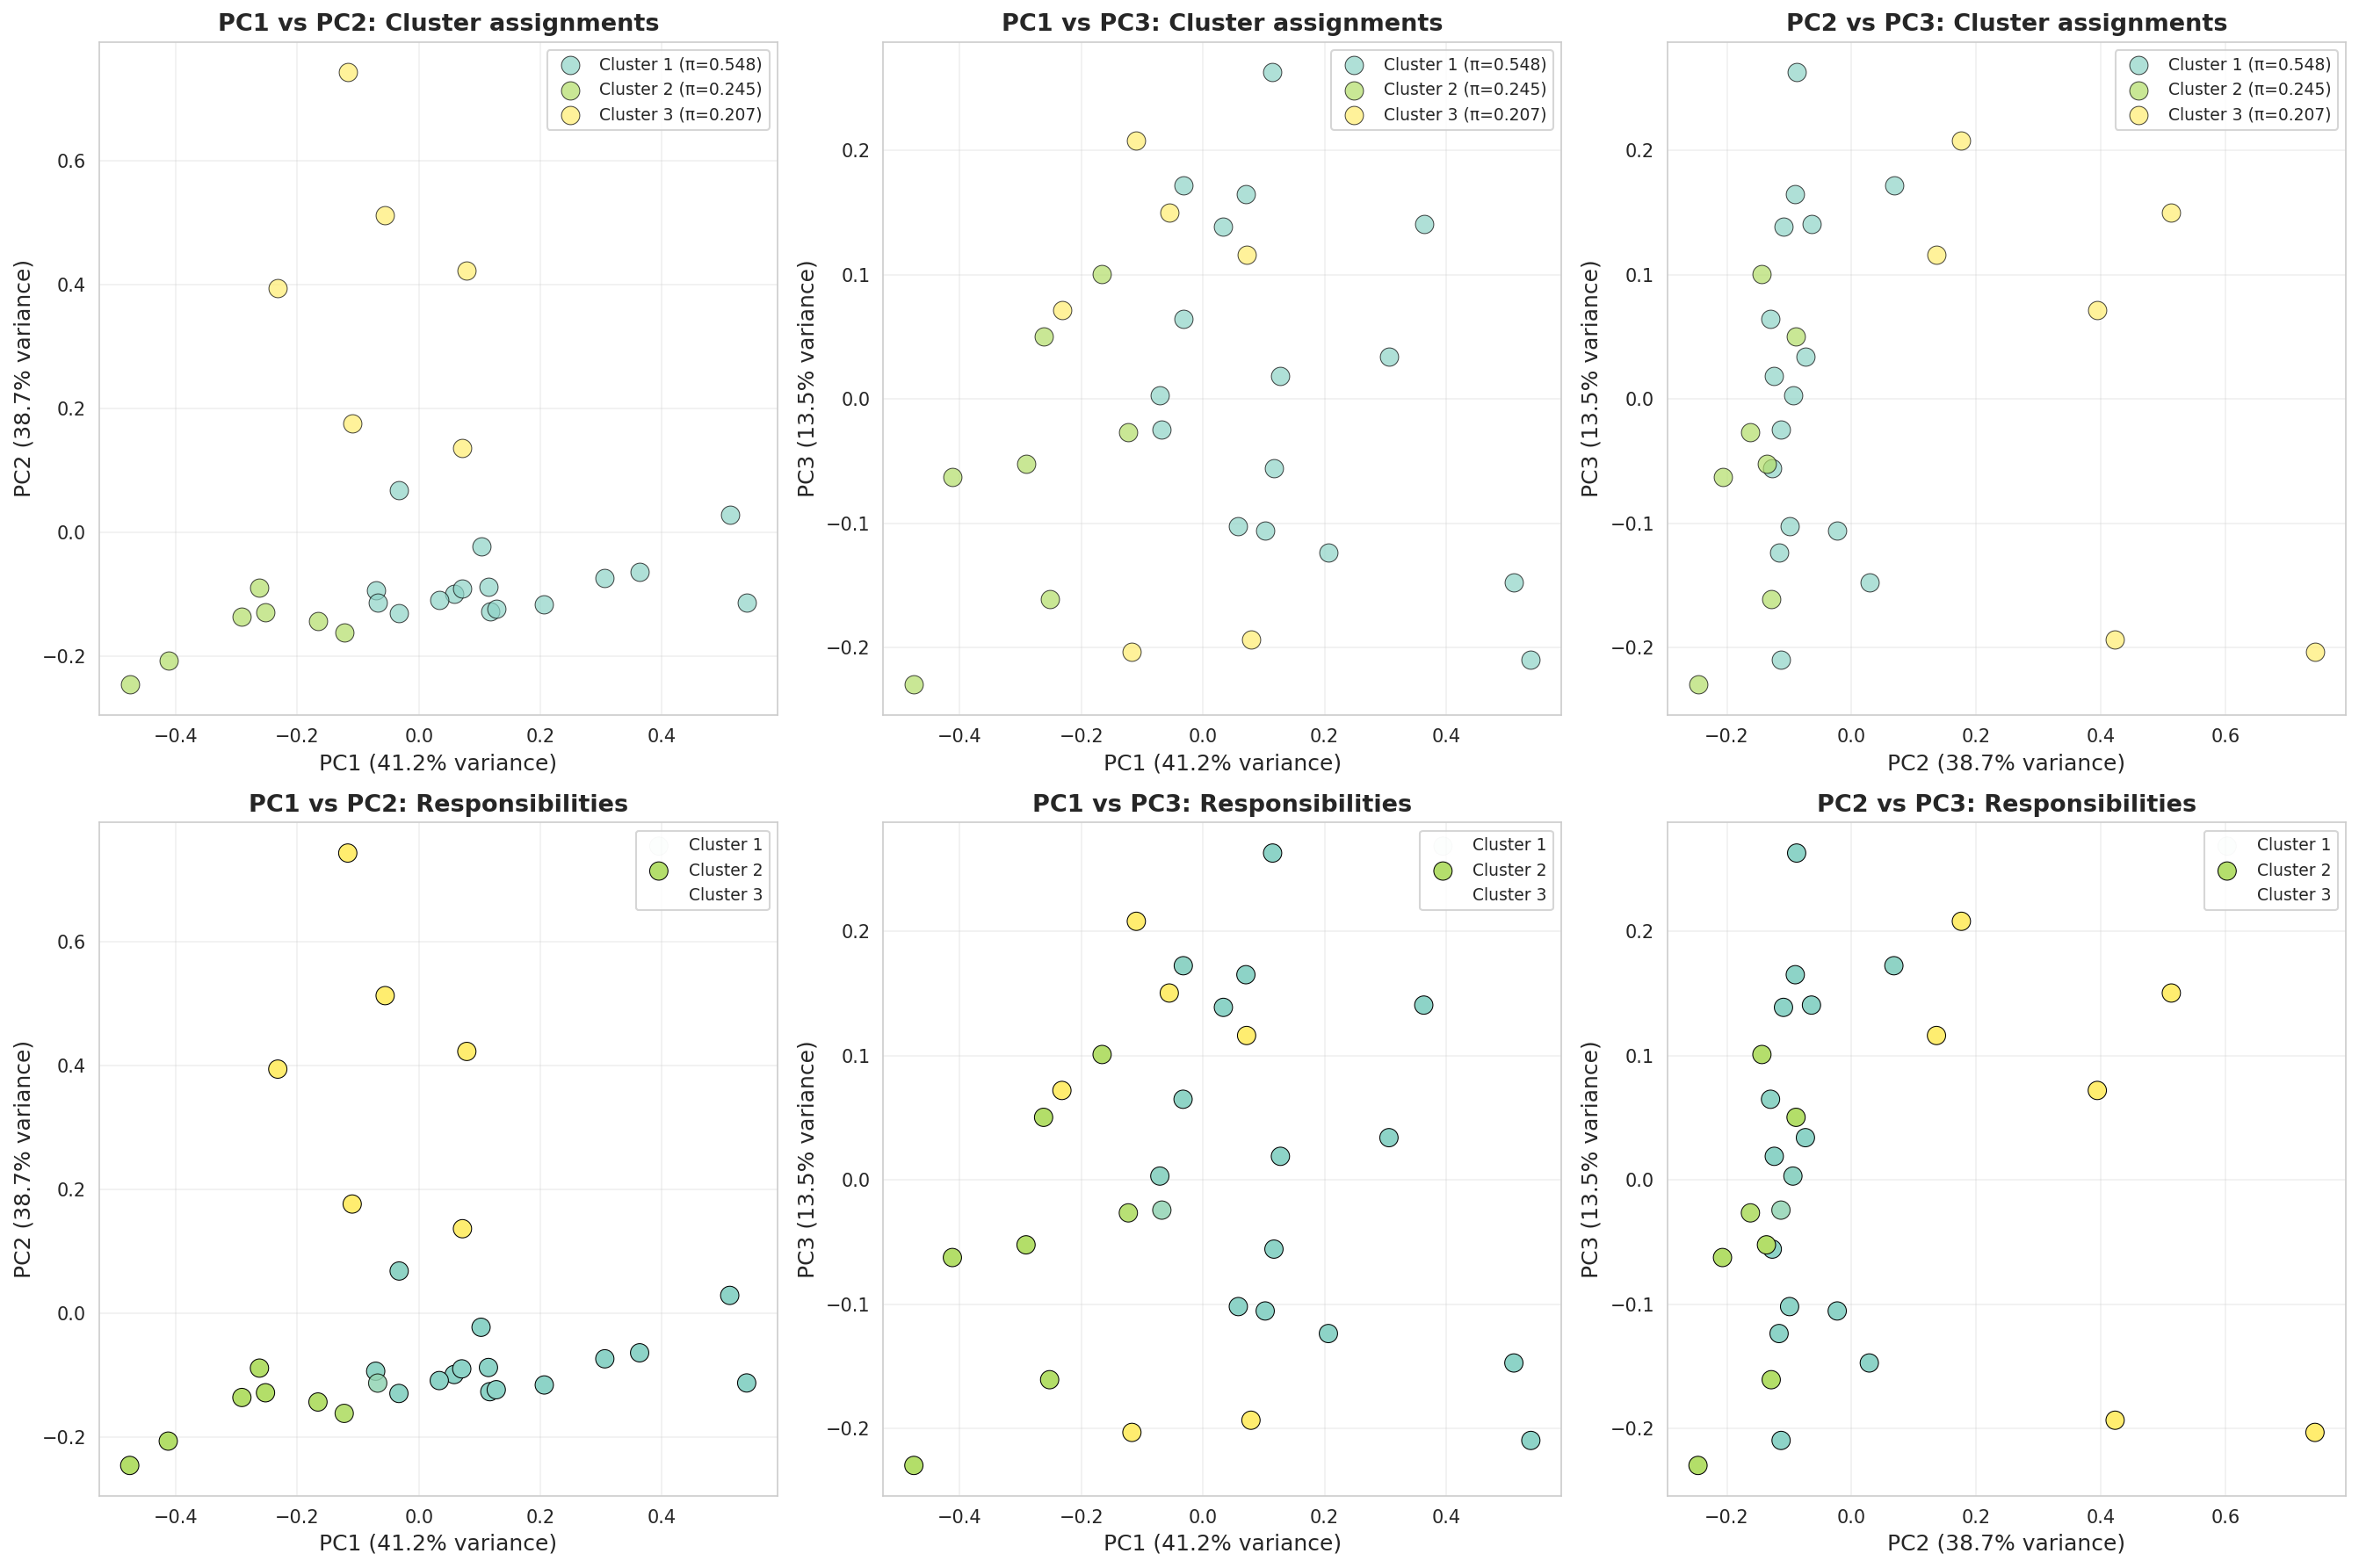

In [ ]:
#%% [code]

# Visualization 1: PCA with 3 components

pca = PCA(n_components=3)
counts_pca = pca.fit_transform(counts_prop)

# Create color map for clusters
colors = plt.cm.Set3(np.linspace(0, 1, n_clusters))

# Create scatterplots for each pair of components
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# PC pairs: (0,1), (0,2), (1,2)
pc_pairs = [(0, 1), (0, 2), (1, 2)]
pc_labels = [('PC1', 'PC2'), ('PC1', 'PC3'), ('PC2', 'PC3')]

# Top row: cluster assignments
for idx, ((pc_x, pc_y), (label_x, label_y)) in enumerate(zip(pc_pairs, pc_labels)):
    ax = axes[0, idx]
    for i in range(n_clusters):
        mask = cluster_assignments == i
        ax.scatter(counts_pca[mask, pc_x], counts_pca[mask, pc_y], 
                   c=[colors[i]], label=f'Cluster {i+1} (π={pi[i]:.3f})', 
                   alpha=0.7, s=100, edgecolors='black', linewidth=0.5)
    
    ax.set_xlabel(f'{label_x} ({pca.explained_variance_ratio_[pc_x]:.1%} variance)', fontsize=12)
    ax.set_ylabel(f'{label_y} ({pca.explained_variance_ratio_[pc_y]:.1%} variance)', fontsize=12)
    ax.set_title(f'{label_x} vs {label_y}: Cluster assignments', fontsize=13, fontweight='bold')
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)

# Bottom row: responsibilities (transparency = responsibility)
for idx, ((pc_x, pc_y), (label_x, label_y)) in enumerate(zip(pc_pairs, pc_labels)):
    ax = axes[1, idx]
    for i in range(n_clusters):
        ax.scatter(counts_pca[:, pc_x], counts_pca[:, pc_y], 
                   c=[colors[i]], alpha=r[:, i], s=100, 
                   edgecolors='black', linewidth=0.5, label=f'Cluster {i+1}')
    
    ax.set_xlabel(f'{label_x} ({pca.explained_variance_ratio_[pc_x]:.1%} variance)', fontsize=12)
    ax.set_ylabel(f'{label_y} ({pca.explained_variance_ratio_[pc_y]:.1%} variance)', fontsize=12)
    ax.set_title(f'{label_x} vs {label_y}: Responsibilities', fontsize=13, fontweight='bold')
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
os.makedirs(f'results/{experiment_version}', exist_ok=True)
plt.savefig(f'results/{experiment_version}/cluster_visualization_pca.png', dpi=150, bbox_inches='tight')
plt.show()

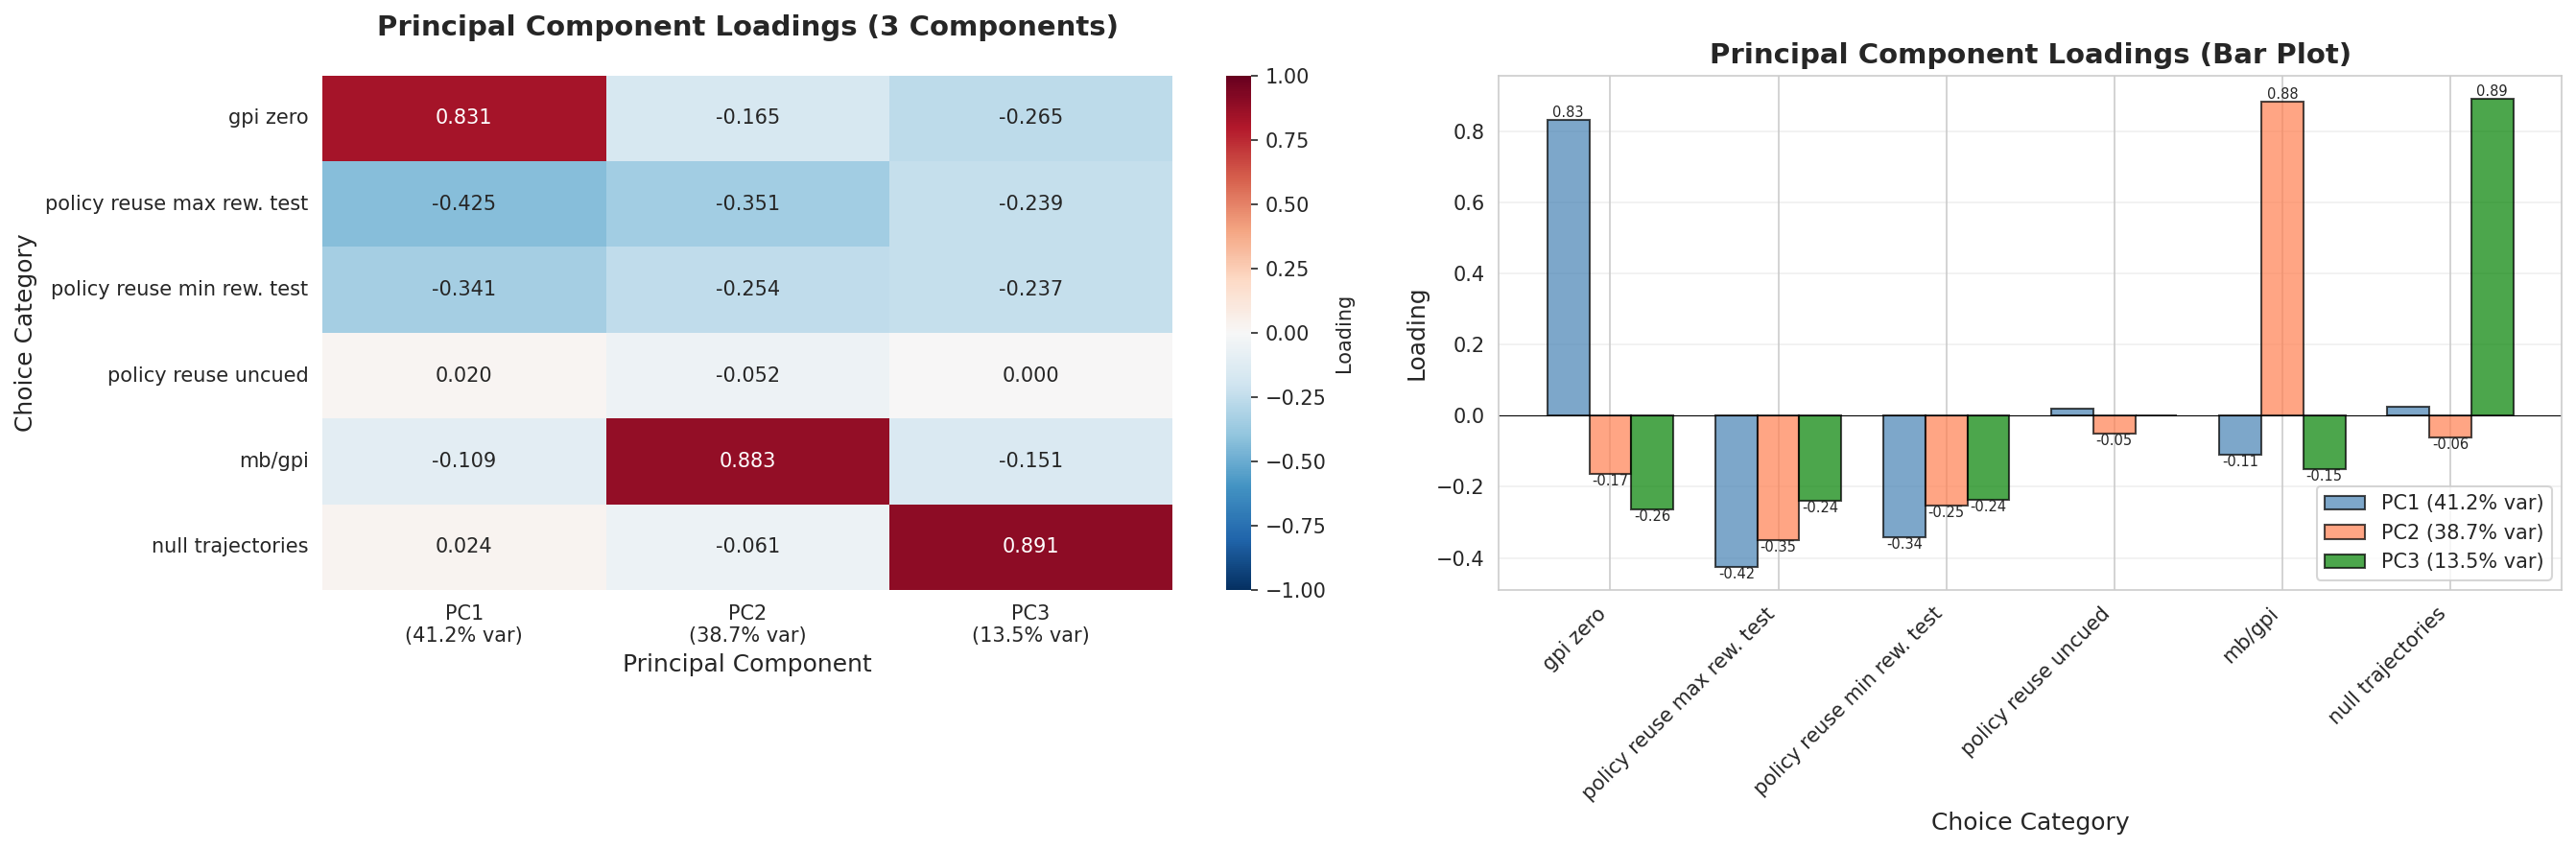


Principal Component Loadings:
                            PC1\n(41.2% var)  PC2\n(38.7% var)  \
gpi zero                            0.830938         -0.165094   
policy reuse max rew. test         -0.424609         -0.350723   
policy reuse min rew. test         -0.341286         -0.253919   
policy reuse uncued                 0.019618         -0.051523   
mb/gpi                             -0.108681          0.882527   
null trajectories                   0.024020         -0.061266   

                            PC3\n(13.5% var)  
gpi zero                           -0.264876  
policy reuse max rew. test         -0.238960  
policy reuse min rew. test         -0.236850  
policy reuse uncued                 0.000450  
mb/gpi                             -0.150779  
null trajectories                   0.891014  

Interpretation:
PC1 explains 41.2% of variance
PC2 explains 38.7% of variance
PC3 explains 13.5% of variance
Together they explain 93.4% of variance


In [ ]:
#%% [code]

# Visualization 1b: Principal Component Loadings

# Get the principal component loadings (components_)
pc_loadings = pca.components_.T  # Transpose to get (n_features, n_components)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Heatmap of PC loadings (all 3 components)
ax = axes[0]
loadings_df = pd.DataFrame(pc_loadings, 
                          index=choice_columns,
                          columns=[f'PC{i+1}\n({pca.explained_variance_ratio_[i]:.1%} var)' 
                                  for i in range(3)])

sns.heatmap(loadings_df, annot=True, fmt='.3f', cmap='RdBu_r', center=0,
            cbar_kws={'label': 'Loading'}, ax=ax, vmin=-1, vmax=1)

ax.set_title('Principal Component Loadings (3 Components)', fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Principal Component', fontsize=12)
ax.set_ylabel('Choice Category', fontsize=12)
plt.xticks(rotation=0)
plt.yticks(rotation=0)

# Plot 2: Bar plot of PC loadings (all 3 components)
ax = axes[1]
x = np.arange(len(choice_columns))
width = 0.25
bars1 = ax.bar(x - width, pc_loadings[:, 0], width, label=f'PC1 ({pca.explained_variance_ratio_[0]:.1%} var)', 
               color='steelblue', alpha=0.7, edgecolor='black')
bars2 = ax.bar(x, pc_loadings[:, 1], width, label=f'PC2 ({pca.explained_variance_ratio_[1]:.1%} var)', 
               color='coral', alpha=0.7, edgecolor='black')
bars3 = ax.bar(x + width, pc_loadings[:, 2], width, label=f'PC3 ({pca.explained_variance_ratio_[2]:.1%} var)', 
               color='green', alpha=0.7, edgecolor='black')

ax.set_xlabel('Choice Category', fontsize=12)
ax.set_ylabel('Loading', fontsize=12)
ax.set_title('Principal Component Loadings (Bar Plot)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(choice_columns, rotation=45, ha='right')
ax.legend()
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        if abs(height) > 0.05:  # Only label if significant
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}', ha='center', 
                    va='bottom' if height > 0 else 'top', fontsize=7)

plt.tight_layout()
plt.savefig(f'results/{experiment_version}/cluster_visualization_pca_loadings.png', dpi=150, bbox_inches='tight')
plt.show()

# Print PC loadings to console
print("\nPrincipal Component Loadings:")
print("=" * 80)
print(loadings_df)
print("\nInterpretation:")
print(f"PC1 explains {pca.explained_variance_ratio_[0]:.1%} of variance")
print(f"PC2 explains {pca.explained_variance_ratio_[1]:.1%} of variance")
print(f"PC3 explains {pca.explained_variance_ratio_[2]:.1%} of variance")
print(f"Together they explain {pca.explained_variance_ratio_.sum():.1%} of variance")

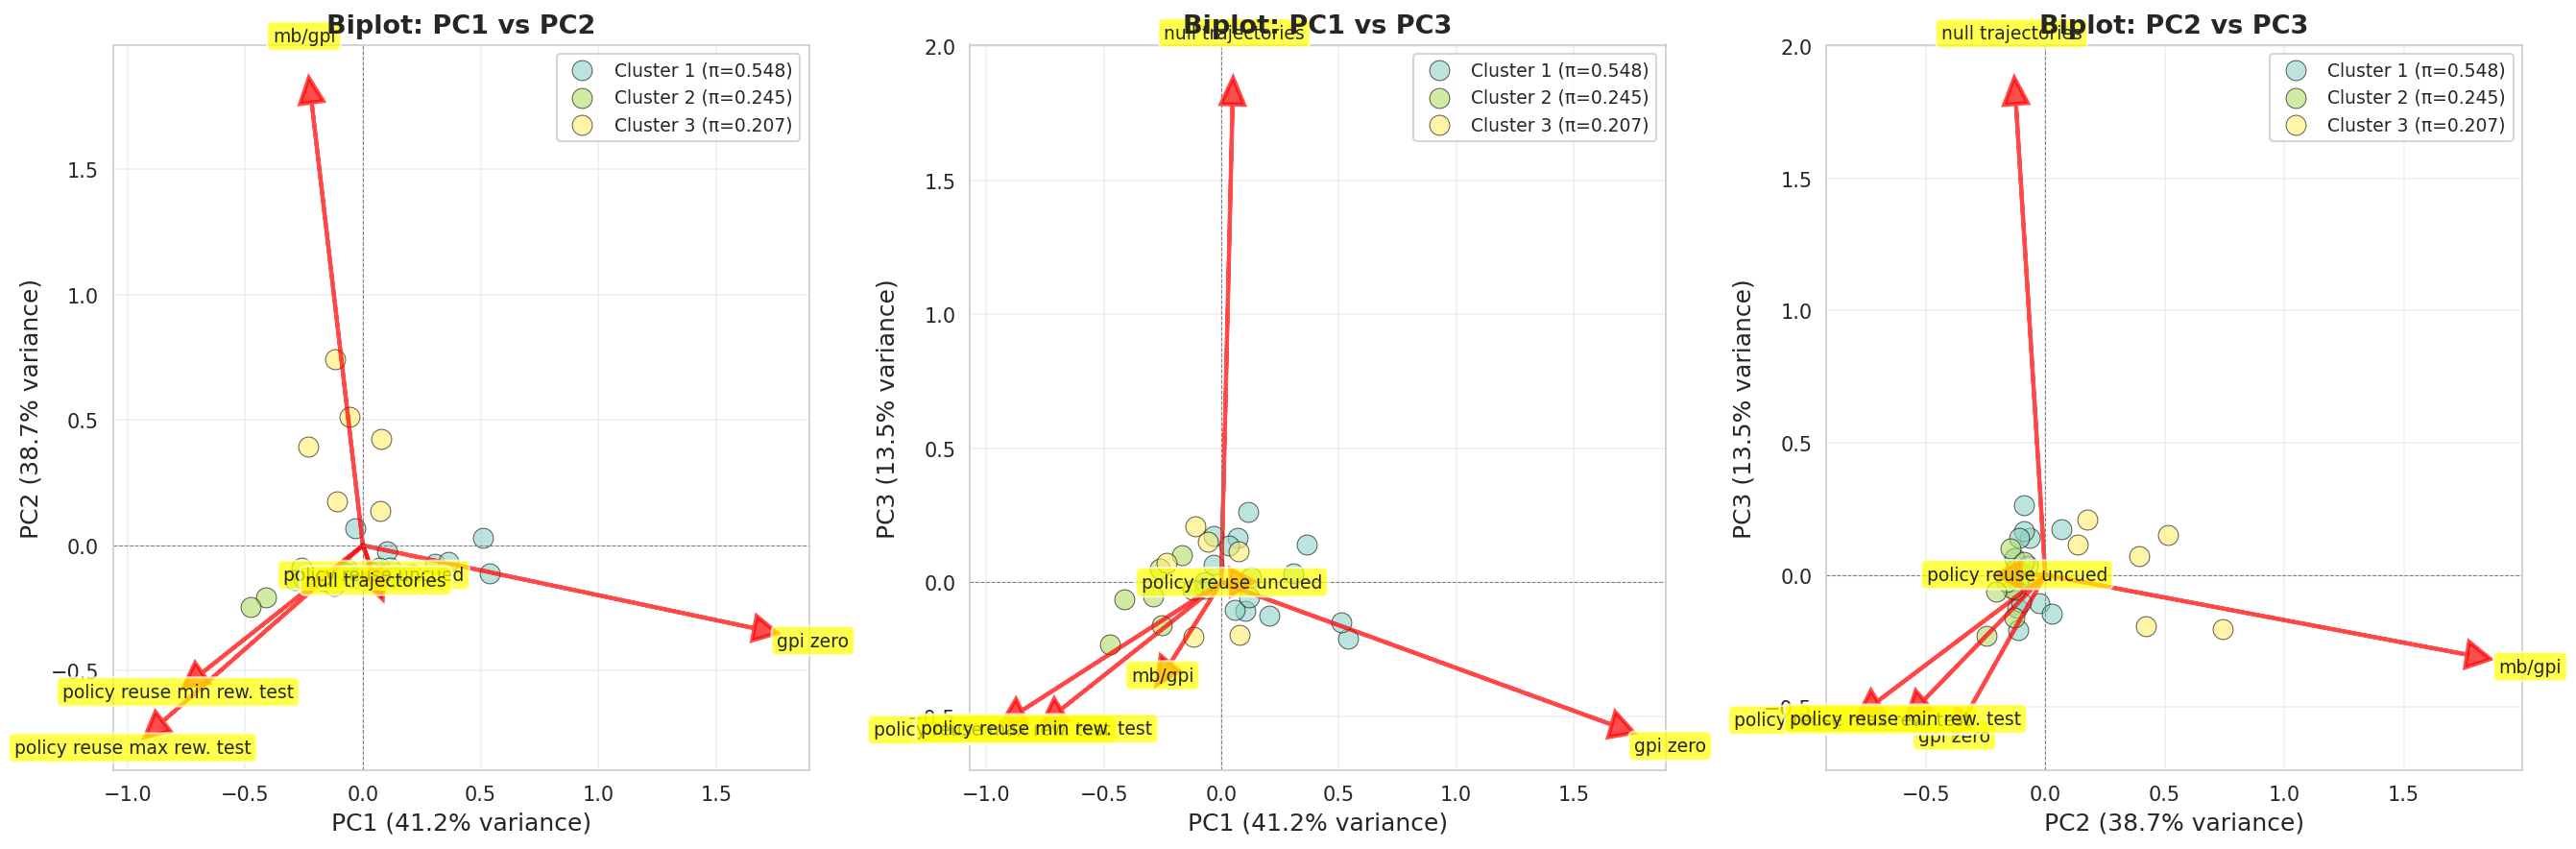

In [ ]:
#%% [code]

# Visualization 1c: PCA Biplots (subjects + variable loadings for each pair)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

pc_pairs = [(0, 1), (0, 2), (1, 2)]
pc_labels = [('PC1', 'PC2'), ('PC1', 'PC3'), ('PC2', 'PC3')]
scale_factor = 2.0  # Adjust this to make arrows more/less prominent

for idx, ((pc_x, pc_y), (label_x, label_y)) in enumerate(zip(pc_pairs, pc_labels)):
    ax = axes[idx]
    
    # Plot subjects colored by cluster
    for i in range(n_clusters):
        mask = cluster_assignments == i
        ax.scatter(counts_pca[mask, pc_x], counts_pca[mask, pc_y], 
                   c=[colors[i]], label=f'Cluster {i+1} (π={pi[i]:.3f})', 
                   alpha=0.6, s=100, edgecolors='black', linewidth=0.5)
    
    # Plot variable loadings as arrows
    for i, (var_name, loading) in enumerate(zip(choice_columns, pc_loadings)):
        ax.arrow(0, 0, loading[pc_x] * scale_factor, loading[pc_y] * scale_factor,
                 head_width=0.1, head_length=0.1, fc='red', ec='red', linewidth=2, alpha=0.7)
        # Add label at the end of arrow
        ax.text(loading[pc_x] * scale_factor * 1.15, loading[pc_y] * scale_factor * 1.15,
                var_name, fontsize=9, ha='center', va='center',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
    
    ax.set_xlabel(f'{label_x} ({pca.explained_variance_ratio_[pc_x]:.1%} variance)', fontsize=12)
    ax.set_ylabel(f'{label_y} ({pca.explained_variance_ratio_[pc_y]:.1%} variance)', fontsize=12)
    ax.set_title(f'Biplot: {label_x} vs {label_y}', fontsize=13, fontweight='bold')
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
    ax.axvline(x=0, color='gray', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig(f'results/{experiment_version}/cluster_visualization_pca_biplot.png', dpi=150, bbox_inches='tight')
plt.show()

/home/momchil.tomov/miniconda3/envs/analysis/lib/python3.12/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


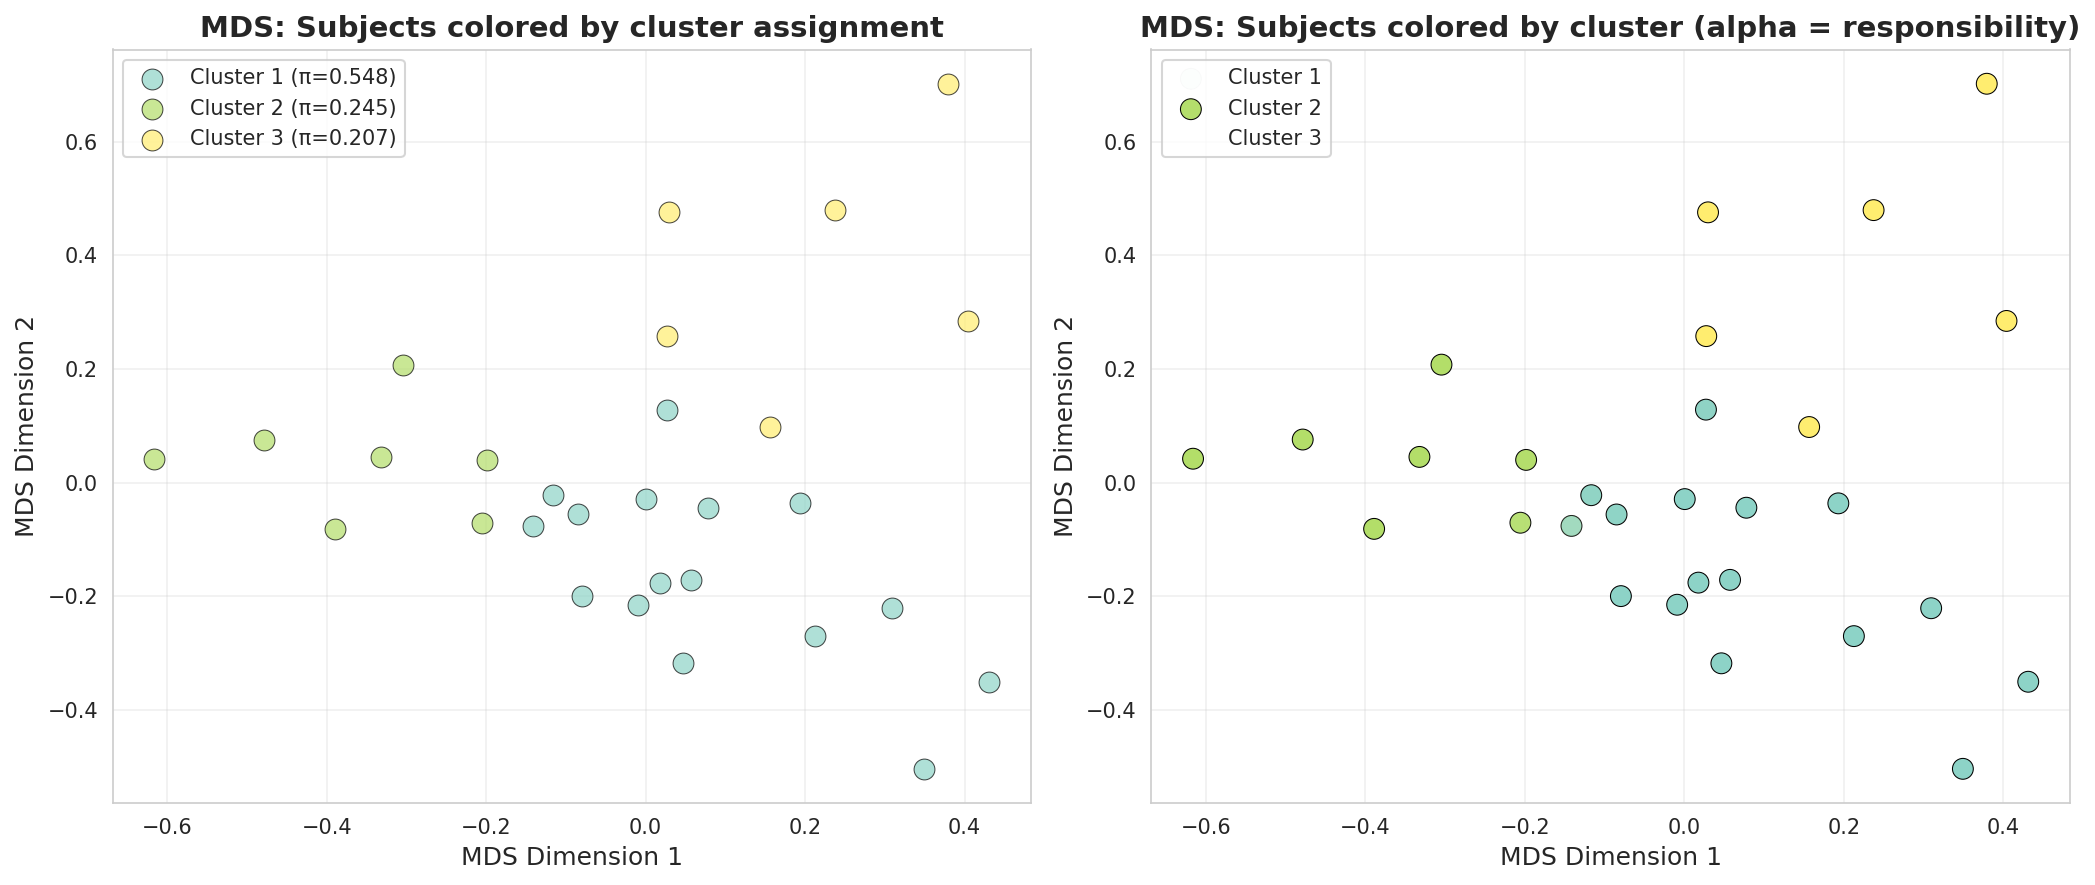

In [ ]:
#%% [code]

# Visualization 2: MDS

mds = MDS(n_components=2, random_state=0, dissimilarity='euclidean')
counts_mds = mds.fit_transform(counts_prop)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: MDS with cluster assignments
ax = axes[0]
for i in range(n_clusters):
    mask = cluster_assignments == i
    ax.scatter(counts_mds[mask, 0], counts_mds[mask, 1], 
               c=[colors[i]], label=f'Cluster {i+1} (π={pi[i]:.3f})', 
               alpha=0.7, s=100, edgecolors='black', linewidth=0.5)

ax.set_xlabel('MDS Dimension 1', fontsize=12)
ax.set_ylabel('MDS Dimension 2', fontsize=12)
ax.set_title('MDS: Subjects colored by cluster assignment', fontsize=14, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

# Plot 2: MDS with responsibilities
ax = axes[1]
for i in range(n_clusters):
    ax.scatter(counts_mds[:, 0], counts_mds[:, 1], 
               c=[colors[i]], alpha=r[:, i], s=100, 
               edgecolors='black', linewidth=0.5, label=f'Cluster {i+1}')

ax.set_xlabel('MDS Dimension 1', fontsize=12)
ax.set_ylabel('MDS Dimension 2', fontsize=12)
ax.set_title('MDS: Subjects colored by cluster (alpha = responsibility)', fontsize=14, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'results/{experiment_version}/cluster_visualization_mds.png', dpi=150, bbox_inches='tight')
plt.show()

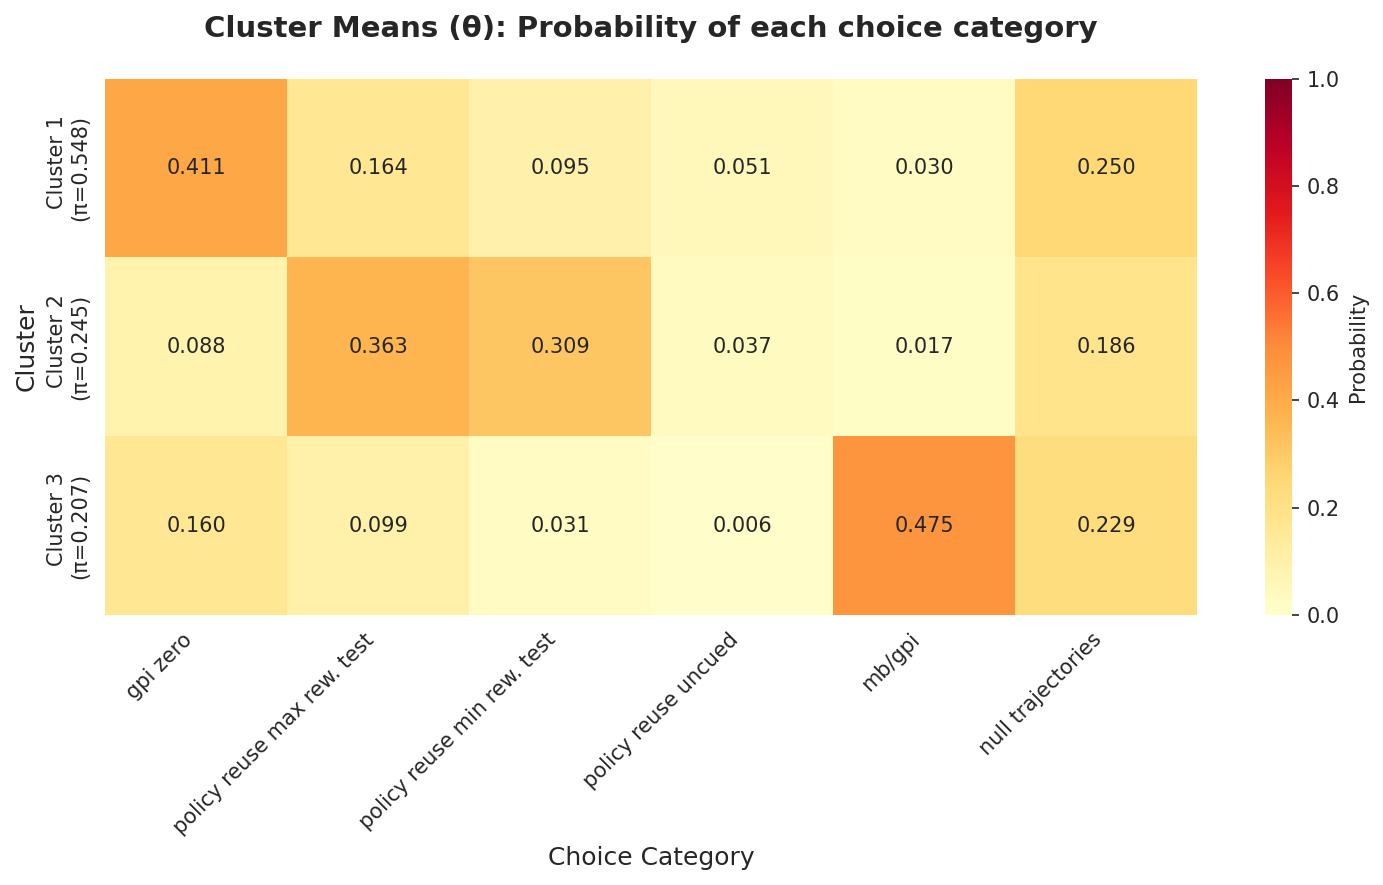

In [ ]:
#%% [code]

# Visualization 3: Cluster means heatmap

fig, ax = plt.subplots(figsize=(10, 6))

# Create heatmap of cluster means
theta_df = pd.DataFrame(theta, 
                        columns=choice_columns,
                        index=[f'Cluster {i+1}\n(π={pi[i]:.3f})' for i in range(n_clusters)])

sns.heatmap(theta_df, annot=True, fmt='.3f', cmap='YlOrRd', 
            cbar_kws={'label': 'Probability'}, ax=ax, vmin=0, vmax=1)

ax.set_title('Cluster Means (θ): Probability of each choice category', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Choice Category', fontsize=12)
ax.set_ylabel('Cluster', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(f'results/{experiment_version}/cluster_visualization_means_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

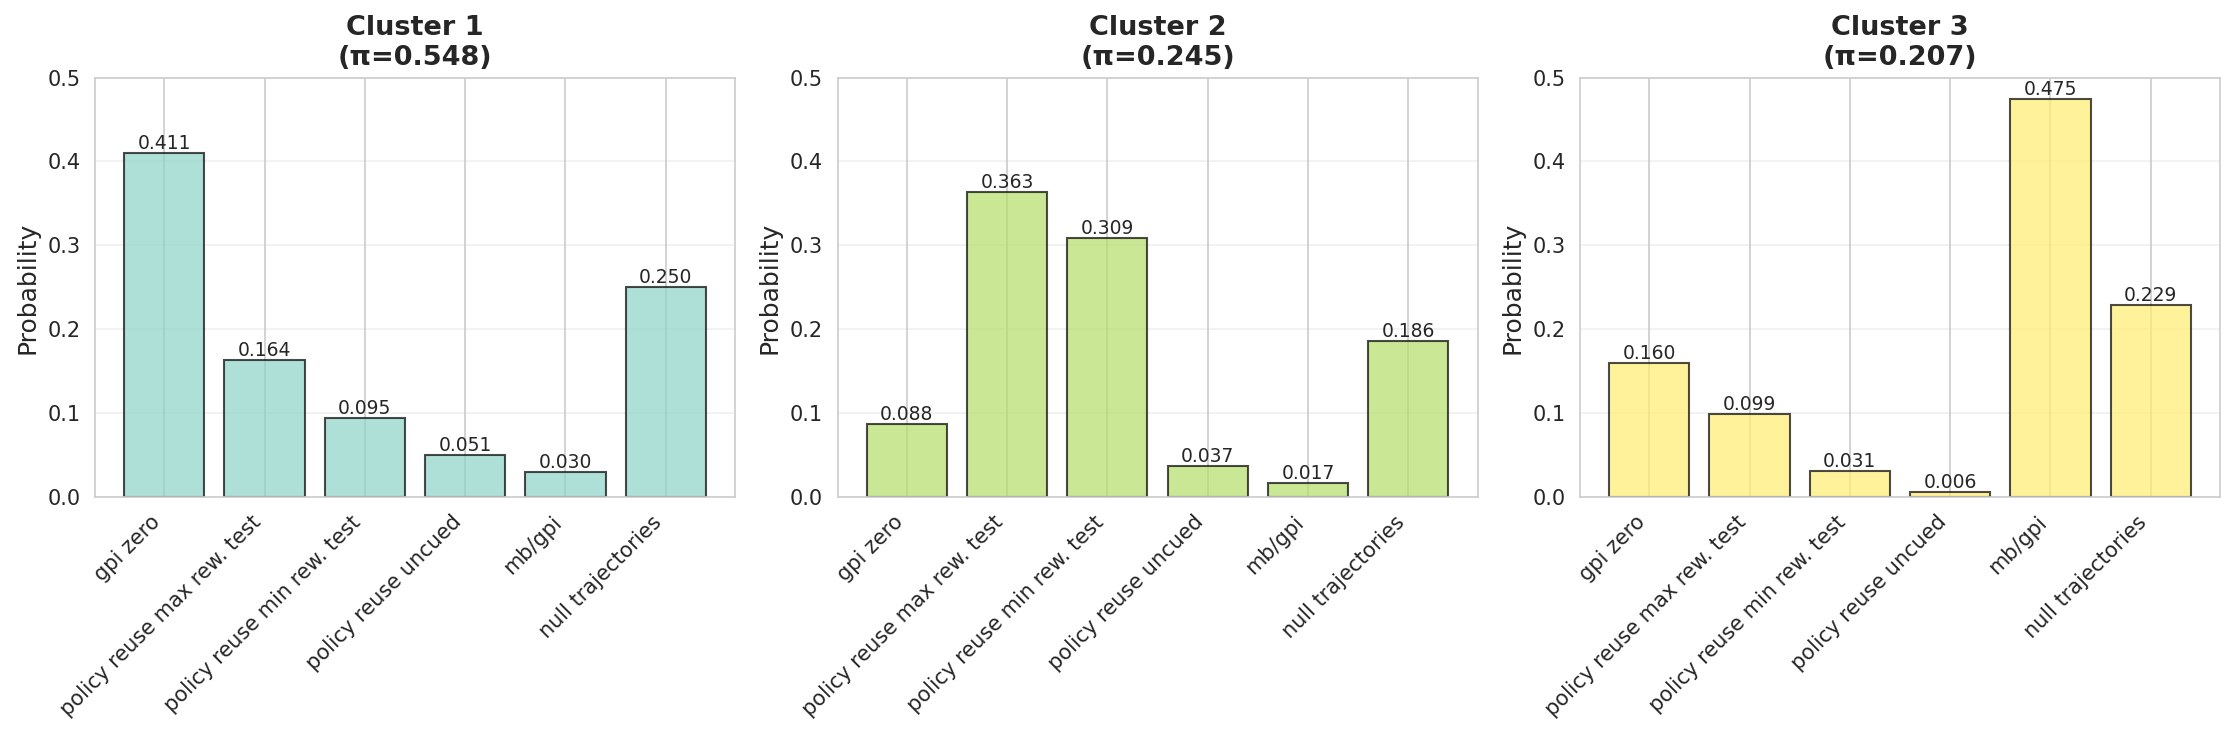

In [ ]:
#%% [code]

# Visualization 4: Cluster means bar plot

fig, axes = plt.subplots(1, n_clusters, figsize=(5*n_clusters, 5))

for i in range(n_clusters):
    ax = axes[i]
    bars = ax.bar(range(len(choice_columns)), theta[i], color=colors[i], alpha=0.7, edgecolor='black')
    ax.set_xticks(range(len(choice_columns)))
    ax.set_xticklabels(choice_columns, rotation=45, ha='right')
    ax.set_ylabel('Probability', fontsize=12)
    ax.set_title(f'Cluster {i+1}\n(π={pi[i]:.3f})', fontsize=13, fontweight='bold')
    ax.set_ylim([0, max(theta.max(), 0.5)])
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for j, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(f'results/{experiment_version}/cluster_visualization_means_bars.png', dpi=150, bbox_inches='tight')
plt.show()

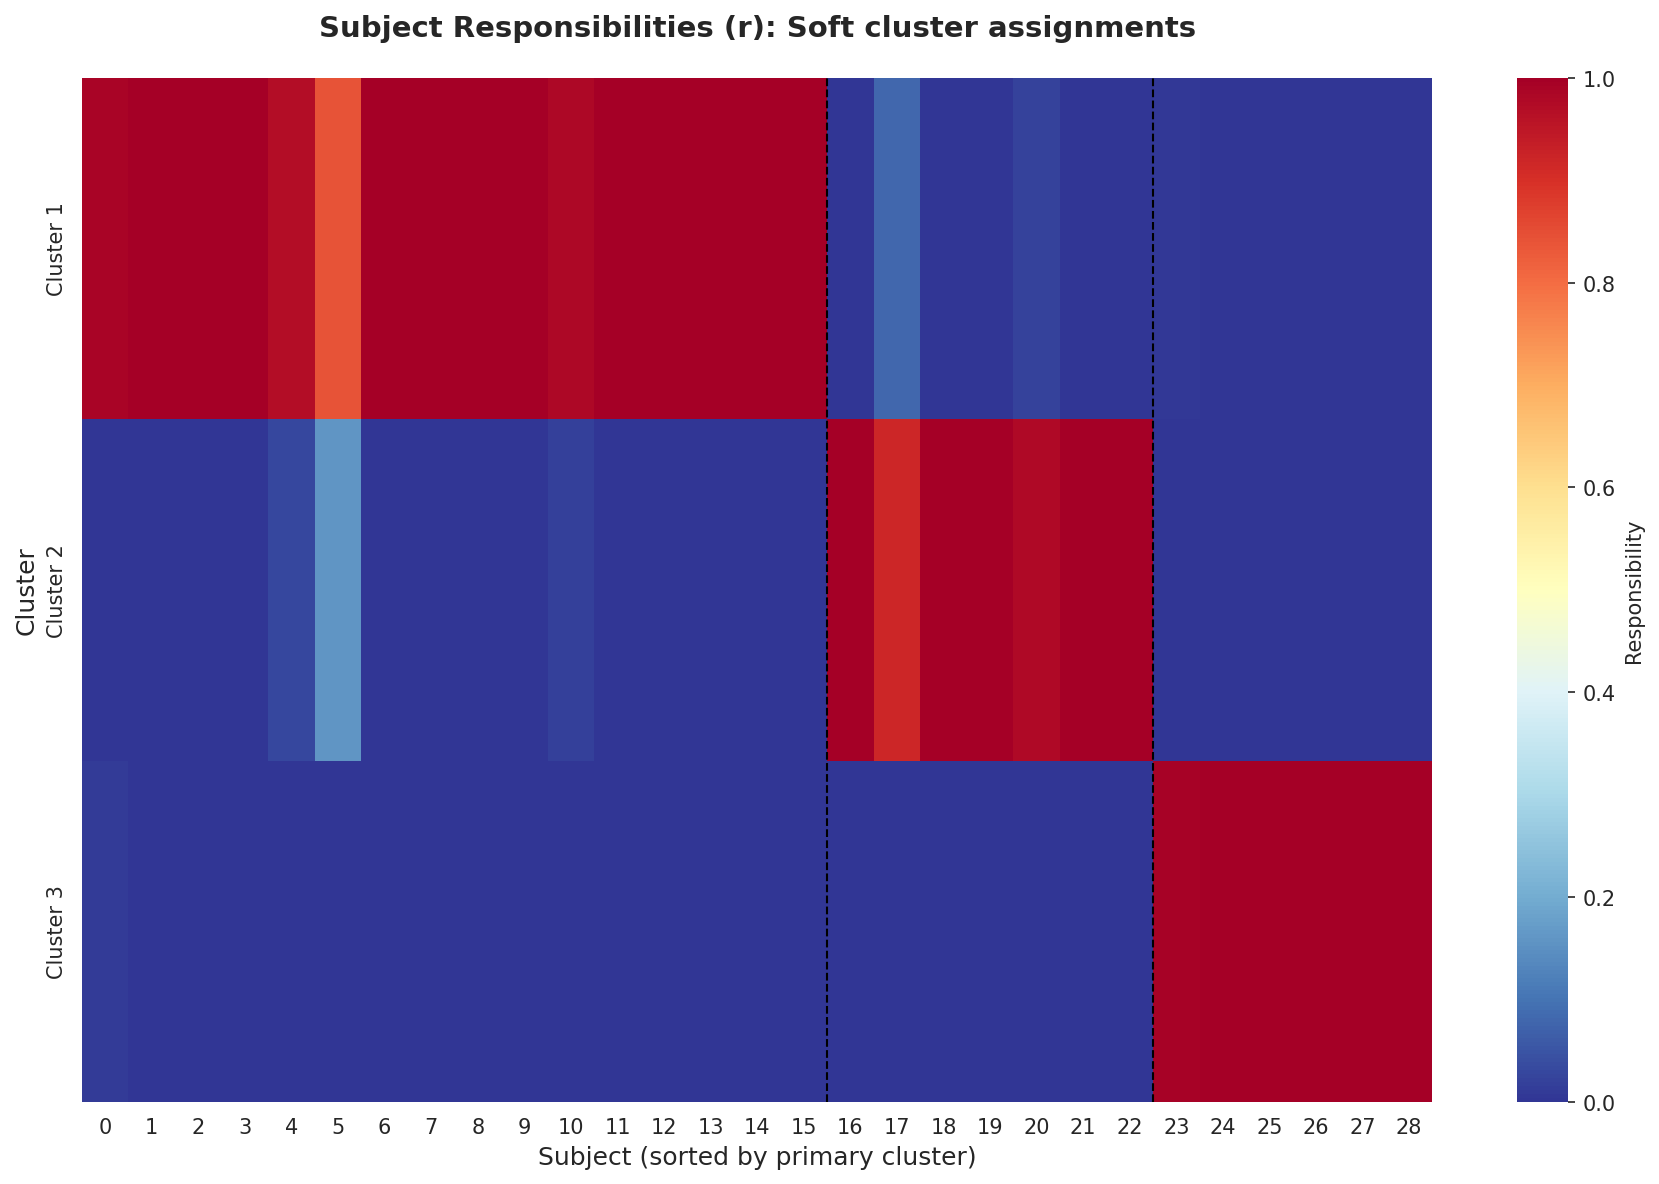

In [ ]:
#%% [code]

# Visualization 5: Responsibilities heatmap

fig, ax = plt.subplots(figsize=(12, 8))

# Sort subjects by their primary cluster assignment for better visualization
sort_idx = np.argsort(cluster_assignments)
r_sorted = r[sort_idx]
cluster_assignments_sorted = cluster_assignments[sort_idx]

# Create heatmap
sns.heatmap(r_sorted.T, annot=False, cmap='RdYlBu_r', 
            cbar_kws={'label': 'Responsibility'}, ax=ax, 
            vmin=0, vmax=1, yticklabels=[f'Cluster {i+1}' for i in range(n_clusters)])

ax.set_title('Subject Responsibilities (r): Soft cluster assignments', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Subject (sorted by primary cluster)', fontsize=12)
ax.set_ylabel('Cluster', fontsize=12)

# Add vertical lines to separate clusters
cumsum = np.cumsum(np.bincount(cluster_assignments_sorted))
for i in range(n_clusters - 1):
    ax.axvline(x=cumsum[i], color='black', linestyle='--', linewidth=1)

plt.tight_layout()
plt.savefig(f'results/{experiment_version}/cluster_visualization_responsibilities.png', dpi=150, bbox_inches='tight')
plt.show()

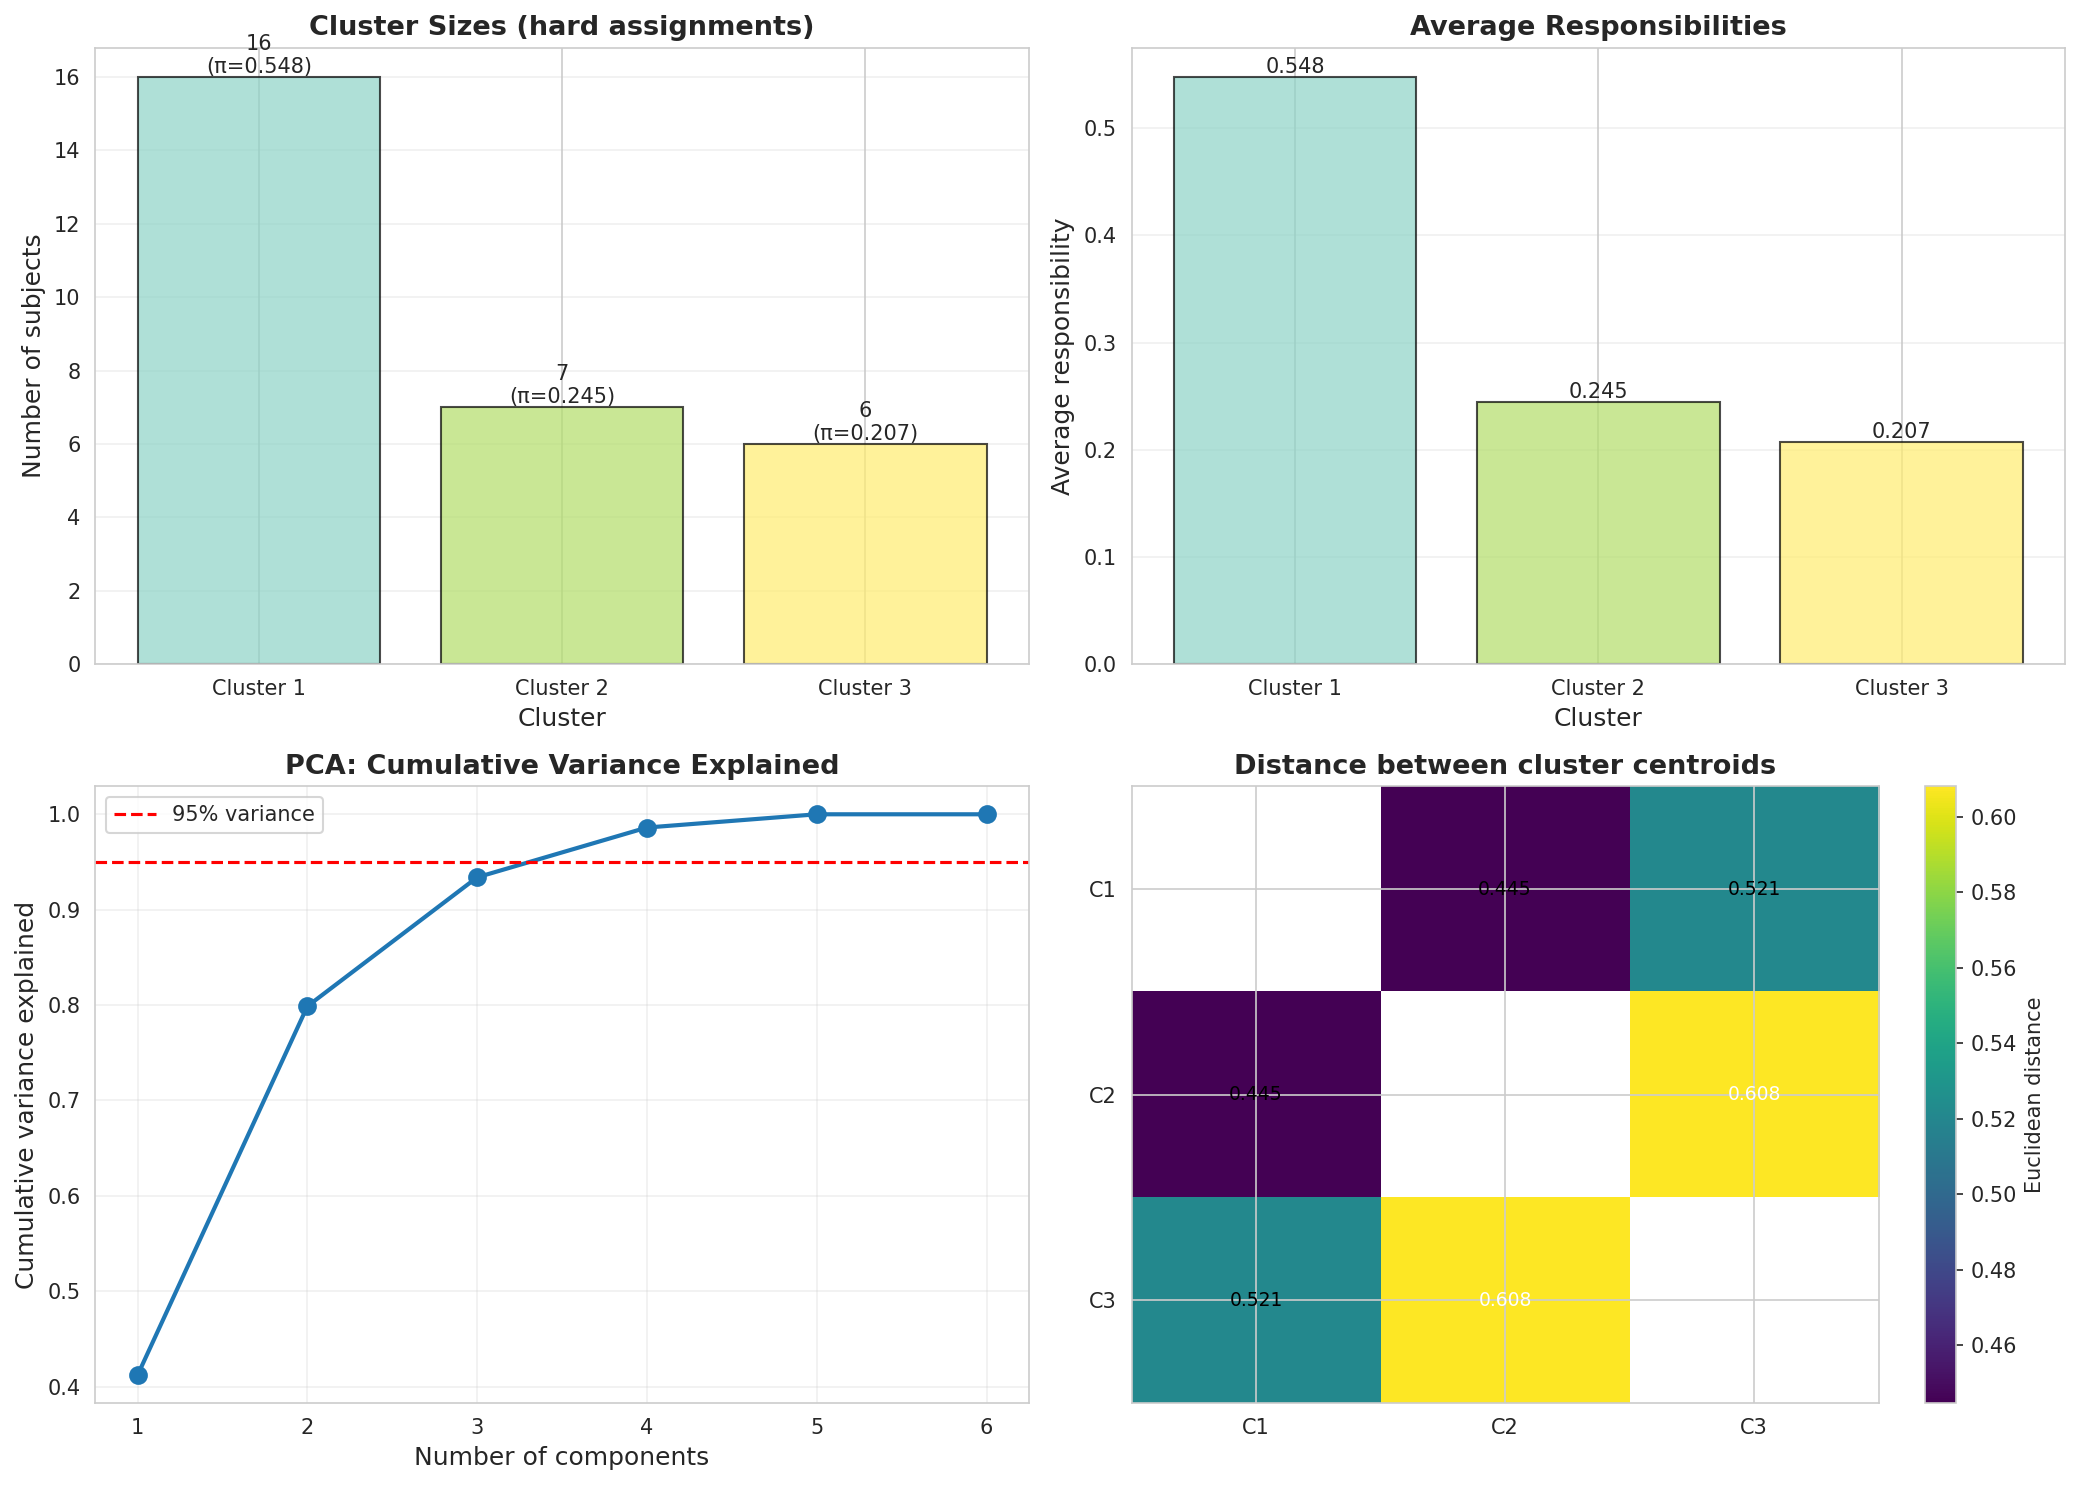

In [ ]:
#%% [code]

# Visualization 6: Summary statistics per cluster

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Cluster sizes
ax = axes[0, 0]
cluster_sizes = np.bincount(cluster_assignments)
bars = ax.bar(range(n_clusters), cluster_sizes, color=colors, alpha=0.7, edgecolor='black')
ax.set_xlabel('Cluster', fontsize=12)
ax.set_ylabel('Number of subjects', fontsize=12)
ax.set_title('Cluster Sizes (hard assignments)', fontsize=13, fontweight='bold')
ax.set_xticks(range(n_clusters))
ax.set_xticklabels([f'Cluster {i+1}' for i in range(n_clusters)])
ax.grid(True, alpha=0.3, axis='y')
for i, (bar, size, prob) in enumerate(zip(bars, cluster_sizes, pi)):
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
            f'{size}\n(π={prob:.3f})', ha='center', va='bottom', fontsize=10)

# Plot 2: Average responsibilities per cluster
ax = axes[0, 1]
avg_responsibilities = r.mean(axis=0)
bars = ax.bar(range(n_clusters), avg_responsibilities, color=colors, alpha=0.7, edgecolor='black')
ax.set_xlabel('Cluster', fontsize=12)
ax.set_ylabel('Average responsibility', fontsize=12)
ax.set_title('Average Responsibilities', fontsize=13, fontweight='bold')
ax.set_xticks(range(n_clusters))
ax.set_xticklabels([f'Cluster {i+1}' for i in range(n_clusters)])
ax.grid(True, alpha=0.3, axis='y')
for i, (bar, avg_r) in enumerate(zip(bars, avg_responsibilities)):
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
            f'{avg_r:.3f}', ha='center', va='bottom', fontsize=10)

# Plot 3: Variance explained by PCA
ax = axes[1, 0]
pca_full = PCA()
pca_full.fit(counts_prop)
cumulative_var = np.cumsum(pca_full.explained_variance_ratio_)
ax.plot(range(1, min(7, len(cumulative_var)+1)), cumulative_var[:6], 'o-', linewidth=2, markersize=8)
ax.axhline(y=0.95, color='r', linestyle='--', label='95% variance')
ax.set_xlabel('Number of components', fontsize=12)
ax.set_ylabel('Cumulative variance explained', fontsize=12)
ax.set_title('PCA: Cumulative Variance Explained', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()

# Plot 4: Cluster separation (distance between cluster centroids)
ax = axes[1, 1]
from scipy.spatial.distance import pdist, squareform
centroids = np.array([counts_prop[cluster_assignments == i].mean(axis=0) for i in range(n_clusters)])
distances = squareform(pdist(centroids))
# Mask diagonal
mask = np.eye(n_clusters, dtype=bool)
distances_masked = np.ma.masked_array(distances, mask=mask)
im = ax.imshow(distances_masked, cmap='viridis', aspect='auto')
ax.set_xticks(range(n_clusters))
ax.set_yticks(range(n_clusters))
ax.set_xticklabels([f'C{i+1}' for i in range(n_clusters)])
ax.set_yticklabels([f'C{i+1}' for i in range(n_clusters)])
ax.set_title('Distance between cluster centroids', fontsize=13, fontweight='bold')
plt.colorbar(im, ax=ax, label='Euclidean distance')
# Add text annotations
for i in range(n_clusters):
    for j in range(n_clusters):
        if i != j:
            ax.text(j, i, f'{distances[i, j]:.3f}', ha='center', va='center', 
                   color='white' if distances[i, j] > distances_masked.mean() else 'black', fontsize=9)

plt.tight_layout()
plt.savefig(f'results/{experiment_version}/cluster_visualization_summary.png', dpi=150, bbox_inches='tight')
plt.show()